# IRL

Easy game formalism :

- States = (x, t)
- Action = (&uarr;, &darr;, &rarr;, &larr;)
- Reward = r(x)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mdptoolbox

FLOAT_MAX = 1e30

In [2]:
# Gridworld provides a basic environment for RL agents to interact with

class GridWorld:
    """
    Grid world environment
    """
    
    def __init__(self, length_max, height, width, start_pos):
        """
            input: 
            height - idx : height of the spatial grid
            width - idx : width of the spatial grid
            length - idx : temporal length of a trip
            
            start_pos 2-tuple : coordinates within the state_space (height x width)
            
        """
        self.height = height
        self.width = width
        self.length_max = length_max
        
        self.start = (0, start_pos[0], start_pos[1])
        self.end = (length_max-1, start_pos[0], start_pos[1])
        
        self.n_states = self.height*self.width*self.length_max
        
        self.actions = [0, 1, 2, 3, 4, 5, 6, 7, 8]
        self.n_actions = len(self.actions)
        self.neighbors = [(0, 0),(-1, 0),(-1, 1),(0, 1),(1, 1),(1, 0),(1, -1),(0, -1),(-1, -1)]
        self.dirs = {0: 'stay', 1: 'n', 2: 'ne', 3: 'e', 4: 'se', 5: 's', 6: 'sw', 7: 'w', 8: 'nw'}
    
    def get_grid_idx(self):
        return np.array(range(self.n_states)).reshape((self.length_max, self.height, self.width))
    
    def get_list_state(self):
        return [(i,j,k) for i in range(self.length_max) for j in range(self.height) for k in range(self.width)]
    
    def state2idx(self, state):
        """
        input:
          2d state
        returns:
          1d index
        """
        return self.get_grid_idx()[state]

    def idx2state(self, idx):
        """
        input:
          1d idx
        returns:
          2d state
        """
        return self.get_list_state()[idx]
           
    def get_next_state(self, state, action):
        """
        get next state with [action] on [state]
        args
          state     (z, y, x)
          action    int
        returns
          new state
        """
        ## force move at first step
        if (action == 0) and (state[0] == 0):
            act = np.random.randint(1, self.n_actions)
        else :
            act = action
                
        if state[0] >= self.length_max-1:
            return state
        else :
            inc = self.neighbors[act]
            nei_s = (state[1] + inc[0], state[2] + inc[1])
            if nei_s[0] >= 0 and nei_s[0] < self.height and nei_s[1] >= 0 and nei_s[1] < self.width:
                next_state = (state[0] + 1, nei_s[0], nei_s[1])
            else:
                next_state = (state[0] + 1, state[1], state[2])
                
            ## finish when back to colony
            if (next_state[1] == self.start[1]) and (next_state[2] == self.start[2]) and (next_state[0]>1) and (next_state[0]<self.length_max-1):
                next_state = self.end                
            return next_state

    def get_list_previous_state(self, state):
        """
        args
          state     (z, y, x)
        returns
          tuple
              - previous state (z, y, x)
              - associated action int
        """
        previous = []
        for a in self.actions:
            inc = self.neighbors[a]
            nei_s = (state[1] - inc[0], state[2] - inc[1])

            if nei_s[0] >= 0 and nei_s[0] < self.height and nei_s[1] >= 0 and nei_s[1] < self.width:
                previous_state = (state[0] - 1, nei_s[0], nei_s[1])
                previous.append((previous_state,a))
        return previous

    def get_transition_mat(self):
        """
        get transition dynamics of the gridworld
        return:
          P_a         NxNxN_ACTIONS transition probabilities matrix - 
                        P_a[s0, s1, a] is the transition prob of 
                        landing at state s1 when taking action 
                        a at state s0
        """
        P_a = np.zeros((self.n_states, self.n_states, self.n_actions))
        
        for i in range(self.n_states):
            si = self.idx2state(i)
            for a in range(self.n_actions):
                sj = self.get_next_state(si,a)
                j = self.state2idx(sj)
                P_a[i, j, a] = 1                
        return P_a

In [3]:
g = GridWorld(8,5,5,(1,1))

In [4]:
g.get_grid_idx()

array([[[  0,   1,   2,   3,   4],
        [  5,   6,   7,   8,   9],
        [ 10,  11,  12,  13,  14],
        [ 15,  16,  17,  18,  19],
        [ 20,  21,  22,  23,  24]],

       [[ 25,  26,  27,  28,  29],
        [ 30,  31,  32,  33,  34],
        [ 35,  36,  37,  38,  39],
        [ 40,  41,  42,  43,  44],
        [ 45,  46,  47,  48,  49]],

       [[ 50,  51,  52,  53,  54],
        [ 55,  56,  57,  58,  59],
        [ 60,  61,  62,  63,  64],
        [ 65,  66,  67,  68,  69],
        [ 70,  71,  72,  73,  74]],

       [[ 75,  76,  77,  78,  79],
        [ 80,  81,  82,  83,  84],
        [ 85,  86,  87,  88,  89],
        [ 90,  91,  92,  93,  94],
        [ 95,  96,  97,  98,  99]],

       [[100, 101, 102, 103, 104],
        [105, 106, 107, 108, 109],
        [110, 111, 112, 113, 114],
        [115, 116, 117, 118, 119],
        [120, 121, 122, 123, 124]],

       [[125, 126, 127, 128, 129],
        [130, 131, 132, 133, 134],
        [135, 136, 137, 138, 139],
        [1

In [5]:
def value_iteration(P_a, rewards, error=0.01, max_iter=100):
    """
    static value iteration function. Perhaps the most useful function in this repo

    inputs:
    P_a         NxNxN_ACTIONS transition probabilities matrix - 
                          P_a[s0, s1, a] is the transition prob of 
                          landing at state s1 when taking action 
                          a at state s0
    rewards     Nx1 matrix - rewards for all the states
    gamma       float - RL discount
    error       float - threshold for a stop

    returns:
    values    Nx1 matrix - estimated values
    policy    Nx1 matrix - policy
    """
    N_STATES, _, N_ACTIONS = np.shape(P_a)
    n = 0 
    values = np.ones([N_STATES])* -FLOAT_MAX
    qvalues = np.ones((N_STATES, N_ACTIONS))* -FLOAT_MAX
    policy = np.zeros((N_STATES, N_ACTIONS))
        
    # estimate values
    while True:
        values_tmp = values.copy()
        values[g.state2idx(g.end)] = 0 # goal
        
        for s in range(N_STATES):
            qvalues[s] = [sum([P_a[s, s1, a]*(rewards[s] + values[s1]) for s1 in range(N_STATES)]) for a in range(N_ACTIONS)]
            
            softmax = max(qvalues[s]) + np.log(1.0 + np.exp(min(qvalues[s]) - max(qvalues[s]))) 
            values[s] = rewards[s] + softmax
            
            policy[s,:] = np.exp(qvalues[s]-values[s])/sum(np.exp(qvalues[s]-values[s]))
            
        if max([abs(values[s] - values_tmp[s]) for s in range(N_STATES)]) < error:
            break
        n += 1
        # max iteration
        if n > max_iter:
            print("    WARNING: max number of iterations", max_iter)
            break    
    
    return values, policy

In [6]:
P = g.get_transition_mat()
R = -np.random.random((g.n_states, 1))

values, policy = value_iteration(P, R, 0.01, 500)

# VALUES = values.reshape((g.length_max, g.height, g.width))

# for j in range(VALUES.shape[2]):
#     plt.imshow(VALUES[:,:,j])
#     plt.show()

In [7]:
def compute_state_visition_freq(P_a, start_idx, nb_step, policy):
    """compute the expected states visition frequency p(s| theta, T) 
    using dynamic programming
    inputs:
    P_a     NxNxN_ACTIONS matrix - transition dynamics
    gamma   float - discount factor
    start_idx   idx of start position
    nb_step idx - nb of step to iterate
    policy  Nx1 vector - policy

    returns:
    p       Nx1 vector - state visitation frequencies
    """
    N_STATES, _, N_ACTIONS = np.shape(P_a)

    # mu[s, t] is the prob of visiting state s at time t
    mu = np.zeros([N_STATES, nb_step]) 

    mu[start_idx, 0] = 1
    for s in range(N_STATES):
        for t in range(nb_step-1):
            mu[s, t+1] = sum([sum([mu[pre_s, t]*P_a[pre_s, s, a1]*policy[pre_s, a1] for a1 in range(N_ACTIONS)]) for pre_s in range(N_STATES)])

    p = np.sum(mu, 1)
    return p

In [8]:
svf = compute_state_visition_freq(P, g.state2idx((0,1,1)), g.length_max, policy)
svf.reshape((g.length_max, g.height, g.width))

array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00]],

       [[1.80265943e-01, 3.41225251e-02, 1.87972225e-01, 0.00000000e+00,
         0.00000000e+00],
        [1.83120129e-01, 0.00000000e+00, 2.92418123e-02, 0.00000000e+00,
         0.00000000e+00],
        [1.52577435e-01, 1.32040512e-01, 1.00659419e-01, 0.00000000e+00,
         0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00]],

      

In [9]:
g.get_grid_idx()

array([[[  0,   1,   2,   3,   4],
        [  5,   6,   7,   8,   9],
        [ 10,  11,  12,  13,  14],
        [ 15,  16,  17,  18,  19],
        [ 20,  21,  22,  23,  24]],

       [[ 25,  26,  27,  28,  29],
        [ 30,  31,  32,  33,  34],
        [ 35,  36,  37,  38,  39],
        [ 40,  41,  42,  43,  44],
        [ 45,  46,  47,  48,  49]],

       [[ 50,  51,  52,  53,  54],
        [ 55,  56,  57,  58,  59],
        [ 60,  61,  62,  63,  64],
        [ 65,  66,  67,  68,  69],
        [ 70,  71,  72,  73,  74]],

       [[ 75,  76,  77,  78,  79],
        [ 80,  81,  82,  83,  84],
        [ 85,  86,  87,  88,  89],
        [ 90,  91,  92,  93,  94],
        [ 95,  96,  97,  98,  99]],

       [[100, 101, 102, 103, 104],
        [105, 106, 107, 108, 109],
        [110, 111, 112, 113, 114],
        [115, 116, 117, 118, 119],
        [120, 121, 122, 123, 124]],

       [[125, 126, 127, 128, 129],
        [130, 131, 132, 133, 134],
        [135, 136, 137, 138, 139],
        [1

In [10]:
## Create expert trajectories

traj_1 = [6, 32, 58, 88, 118, 142, 161, 181]
traj_2 = [6, 36, 67, 98, 117, 137, 157, 191]
traj_3 = [6, 37, 57, 87, 112, 136, 162, 181]
traj_4 = [6, 37, 67, 93, 118, 137, 181]
traj_5 = [6, 32, 61, 87, 181]
traj_6 = [6, 37, 63, 92, 112, 181]

trajs = [traj_1, traj_2, traj_3, traj_4, traj_5, traj_6]


freq = np.zeros((5,5))
for traj in trajs:
    for idx in traj:
        state = g.idx2state(idx)
        freq[state[1], state[2]] += 1
        
freq

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0., 11.,  4.,  1.,  0.],
       [ 0.,  4., 10.,  2.,  0.],
       [ 0.,  1.,  5.,  3.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [56]:
## feat_map

map_mask = [[-1, -1, -1, 0, 0],
            [-1, 0, 0, 0, 0],
            [-1, 0, 0, 0, 0],
            [-1, 0, 0, 0, 0],
            [-1, 0, 0, 0, 0]]

map_dist = [[-0.3, -0.3, -0.3, -0.6, -0.9],
            [-0.3, 0, -0.3, -0.6, -0.9],
            [-0.3, -0.3, -0.3, -0.6, -0.9],
            [-0.6, -0.6, -0.6, -0.9, -1],
            [-0.9, -0.9, -0.9, -1, -1]]

map_gradv = [[0, 0, 0, 0, 0],
            [-0.2, -0.2, -0.2, -0.2, -0.2],
            [-0.4, -0.4, -0.4, -0.4, -0.4],
            [-0.6, -0.6, -0.6, -0.6, -0.6],
            [-0.8, -0.8, -0.8, -0.8, -0.8]]

map_gradh = [[0, -0.2, -0.4, -0.6, -0.8],
            [0, -0.2, -0.4, -0.6, -0.8],
            [0, -0.2, -0.4, -0.6, -0.8],
            [0, -0.2, -0.4, -0.6, -0.8],
            [0, -0.2, -0.4, -0.6, -0.8]]

map_const = [[-1, -1, -1, -1, -1],
            [-1, -1, -1, -1, -1],
            [-1, -1, -1, -1, -1],
            [-1, -1, -1, -1, -1],
            [-1, -1, -1, -1, -1]]


list_feat_map = [map_mask, map_dist, map_gradv, map_gradh, map_const]
FEAT_MAP = []

# for j in range(g.length_max):
feature_list =[]
for t in range(g.length_max):
#         coeff = [1 if t == j else 0]
    coeff = 1
    feature =  coeff * np.array([map_mask, map_dist, map_gradv, map_gradh, map_const]).reshape(5,25).T
    feature_list.append(feature)
    
feat_map = np.vstack(feature_list)
#     FEAT_MAP.append(feat_map)
    
# feat_map = np.hstack(FEAT_MAP)

In [57]:
feat_map[:,0]

array([-1., -1., -1.,  0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,
        0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0., -1.,
       -1., -1.,  0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,
        0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0., -1., -1.,
       -1.,  0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,
       -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0., -1., -1., -1.,
        0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0., -1.,
        0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0., -1., -1., -1.,  0.,
        0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,
        0.,  0.,  0., -1.,  0.,  0.,  0.,  0., -1., -1., -1.,  0.,  0.,
       -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,
        0.,  0., -1.,  0.,  0.,  0.,  0., -1., -1., -1.,  0.,  0., -1.,
        0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,
        0., -1.,  0.,  0.,  0.,  0., -1., -1., -1.,  0.,  0., -1

In [58]:
def maxent_irl(feat_map, P_a, trajs, lr, error, max_iter):
    """
    Maximum Entropy Inverse Reinforcement Learning (Maxent IRL)
    inputs:
    feat_map    NxD matrix - the features for each state
    P_a         NxNxN_ACTIONS matrix - P_a[s0, s1, a] is the transition prob of 
                                       landing at state s1 when taking action 
                                       a at state s0
    gamma       float - RL discount factor
    trajs       a list of demonstrations
    lr          float - learning rate
    n_iters     int - number of optimization steps
    returns
    rewards     Nx1 vector - recoverred state rewards
    """
    N_STATES, _, N_ACTIONS = np.shape(P_a)

    # init parameters
    theta = np.ones(feat_map.shape[1])*0.5
    
    # calc feature expectations
    feat_exp = np.zeros([feat_map.shape[1]])
    for episode in trajs:
        for step in episode:
            feat_exp += feat_map[step,:]
    feat_exp = feat_exp/len(trajs)

    n = 0
    error_history = []
    # training
    while True:
        n += 1
        if n % (max_iter/20) == 0:
            print('iteration: {}/{}'.format(n, max_iter))

        # compute reward function
        rewards = np.dot(feat_map, theta)

        # compute policy
        _, policy = value_iteration(P_a, rewards, error=0.01, max_iter=100)

        # compute state visition frequences
        svf = compute_state_visition_freq(P_a, g.state2idx((0,1,1)), g.length_max, policy)
        
        # compute gradients
        grad = feat_exp - feat_map.T.dot(svf)
                
        # update params
        theta *= np.exp(lr * grad)
       
        error_history.append(sum(grad**2))
        if sum(grad**2) < error:
            break
        # max iteration
        if n > max_iter:
            print("    WARNING: max number of iterations", max_iter)
            break 
            
    rewards = np.dot(feat_map, theta)
    return rewards, policy, error_history

In [59]:
rewards, policy, error_history = maxent_irl(feat_map, P, trajs, 0.1, 0.01, 100)

iteration: 5/100
iteration: 10/100
iteration: 15/100
iteration: 20/100
iteration: 25/100
iteration: 30/100
iteration: 35/100
iteration: 40/100
iteration: 45/100
iteration: 50/100
iteration: 55/100
iteration: 60/100
iteration: 65/100
iteration: 70/100
iteration: 75/100
iteration: 80/100
iteration: 85/100
iteration: 90/100


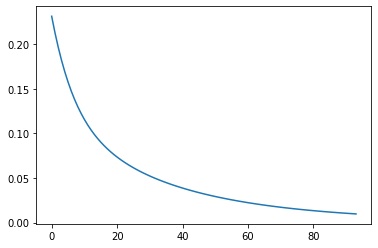

In [60]:
plt.plot(error_history)

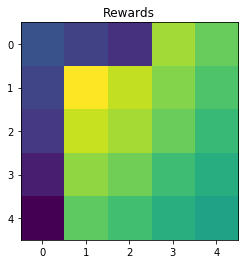

In [61]:
rewards_grid = rewards.reshape((g.length_max, g.height, g.width))
rewards_grid = rewards_grid[0,:,:]

# Map

plt.imshow(rewards_grid);
plt.title('Rewards')
plt.show()

In [62]:
def generate_demonstrations(g, policy, n_trajs=10, len_traj=5):
    """gatheres expert demonstrations
    inputs:
    policy      Nx1 matrix
    n_trajs     int - number of trajectories to generate
    rand_start  bool - randomly picking start position or not
    start_pos   2x1 list - set start position, default [0,0]
    returns:
    trajs       a list of trajectories - each element in the list is a list of Steps representing an episode
    """

    trajs = []
    for i in range(n_trajs):
        
        episode = []
        state = (0,1,1)
        idx = g.state2idx(state)
        episode.append(idx)
        
        # while not is_done:
        for _ in range(len_traj-1):

            act = np.random.choice(g.n_actions, p= policy[idx,:])
            next_state = g.get_next_state(state, act)
            next_idx = g.state2idx(next_state)
            episode.append(next_idx)
            state = next_state
            idx = next_idx
            
        trajs.append(episode)
    return trajs

In [63]:
trajs = generate_demonstrations(g, policy, 50, 8)
trajs

[[6, 37, 57, 181, 181, 181, 181, 181],
 [6, 37, 181, 181, 181, 181, 181, 181],
 [6, 36, 181, 181, 181, 181, 181, 181],
 [6, 26, 181, 181, 181, 181, 181, 181],
 [6, 26, 57, 181, 181, 181, 181, 181],
 [6, 35, 181, 181, 181, 181, 181, 181],
 [6, 26, 55, 181, 181, 181, 181, 181],
 [6, 36, 57, 77, 181, 181, 181, 181],
 [6, 36, 181, 181, 181, 181, 181, 181],
 [6, 26, 181, 181, 181, 181, 181, 181],
 [6, 26, 181, 181, 181, 181, 181, 181],
 [6, 37, 181, 181, 181, 181, 181, 181],
 [6, 36, 181, 181, 181, 181, 181, 181],
 [6, 36, 55, 181, 181, 181, 181, 181],
 [6, 36, 61, 82, 101, 126, 151, 181],
 [6, 26, 51, 181, 181, 181, 181, 181],
 [6, 37, 181, 181, 181, 181, 181, 181],
 [6, 30, 181, 181, 181, 181, 181, 181],
 [6, 37, 181, 181, 181, 181, 181, 181],
 [6, 35, 181, 181, 181, 181, 181, 181],
 [6, 26, 181, 181, 181, 181, 181, 181],
 [6, 32, 181, 181, 181, 181, 181, 181],
 [6, 32, 62, 82, 112, 181, 181, 181],
 [6, 30, 181, 181, 181, 181, 181, 181],
 [6, 37, 62, 82, 112, 136, 181, 181],
 [6, 32, 57, 

In [64]:
freq = np.zeros((5,5))
for traj in trajs:
    traj = np.unique(traj)
    for idx in traj:
        state = g.idx2state(idx)
        freq[state[1], state[2]] += 1
        
freq

array([[  5.,  12.,   3.,   0.,   0.],
       [  9., 100.,  16.,   0.,   0.],
       [  6.,  19.,  19.,   0.,   0.],
       [  0.,   0.,   1.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.]])